In [1]:
#https://data.mendeley.com/datasets/5y9wdsg2zt/1 (data)
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


Using TensorFlow backend.


In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(227,227,3))


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [46]:


base_dir = '/home/rongzhen/chalmers/digital_twin/crack_image/CNN_GPU'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 100

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 28000)
validation_features, validation_labels = extract_features(validation_dir, 8000)
test_features, test_labels = extract_features(test_dir, 4000)

Found 28000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [47]:
train_features.shape,validation_features.shape,test_features.shape

((28000, 7, 7, 512), (8000, 7, 7, 512), (4000, 7, 7, 512))

In [49]:
train_features = np.reshape(train_features, (28000, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (8000, 7 * 7 * 512))
test_features = np.reshape(test_features, (4000, 7 * 7 * 512))

In [50]:
train_features.shape,validation_features.shape,test_features.shape

((28000, 25088), (8000, 25088), (4000, 25088))

In [51]:
from keras import models, layers, optimizers

In [52]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7*7*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30, batch_size=10, validation_data=(validation_features, validation_labels))

Train on 28000 samples, validate on 8000 samples
Epoch 1/30
28000/28000 [==============================] - 33s 1ms/step - loss: 0.0444 - acc: 0.9864 - val_loss: 0.0196 - val_acc: 0.9940
Epoch 2/30
28000/28000 [==============================] - 33s 1ms/step - loss: 0.0234 - acc: 0.9930 - val_loss: 0.0204 - val_acc: 0.9939
Epoch 3/30
28000/28000 [==============================] - 33s 1ms/step - loss: 0.0215 - acc: 0.9944 - val_loss: 0.0208 - val_acc: 0.9950
Epoch 4/30
28000/28000 [==============================] - 33s 1ms/step - loss: 0.0206 - acc: 0.9944 - val_loss: 0.0205 - val_acc: 0.9951
Epoch 5/30
28000/28000 [==============================] - 33s 1ms/step - loss: 0.0211 - acc: 0.9949 - val_loss: 0.0200 - val_acc: 0.9940
Epoch 6/30
28000/28000 [==============================] - 33s 1ms/step - loss: 0.0218 - acc: 0.9952 - val_loss: 0.0233 - val_acc: 0.9940
Epoch 7/30
28000/28000 [==============================] - 33s 1ms/step - loss: 0.0210 - acc: 0.9954 - val_loss: 0.0206 - val_acc:

In [55]:
model.save('crack_pretrain_easy_gpu.h5')

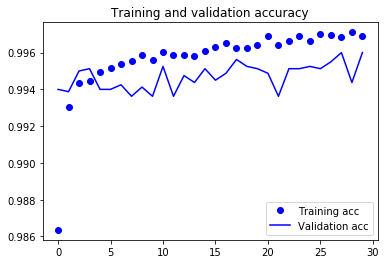

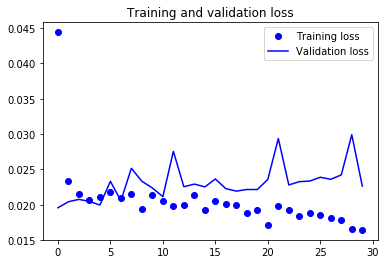

In [54]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [67]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
img = image.load_img(train_dir+'/pos/00001.jpg')

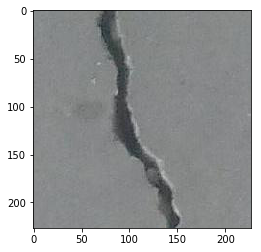

In [68]:
plt.imshow(img)

In [81]:
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

In [89]:
x.shape

(1, 227, 227, 3)

In [92]:
features =conv_base.predict(x)

In [94]:
features = np.reshape(features, (1, 7 * 7 * 512))

In [96]:
features.shape

(1, 25088)

In [98]:
preds = model.predict(features)

In [101]:
from keras.applications.vgg16 import preprocess_input, decode_predictions

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 1)

# another method for pretrain model (Flexible for augmentation)

In [57]:
model_conv_base = models.Sequential()
model_conv_base.add(conv_base)
model_conv_base.add(layers.Flatten())
model_conv_base.add(layers.Dense(256, activation='relu'))
model_conv_base.add(layers.Dense(1,  activation='sigmoid'))

In [58]:
model_conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [59]:
conv_base.trainable = False